In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow_probability import distributions as tfd

import pymc as pm  # use PyMC version 4.4.0
import arviz as az
import aesara.tensor as at

2023-05-29 03:29:00.558189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 03:29:00.684600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-29 03:29:00.684617: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-29 03:29:00.700420: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-29 03:29:01.085375: W tensorflow/stream_executor/platform/de

In [2]:
from bayesflow.amortizers import AmortizedLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_losses
from bayesflow.mcmc import PyMCSurrogateLikelihood

from utility_functions import feather_loader

# customized plotting functions
from plotting_functions import compare_estimates, plot_recovery
import pandas as pd

/data/Programming/IWR/JANA-revision/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Simple drift-diffusion model: MCMC sampling using the surrogate likelihood

For many processes, methods like MCMC sampling are infeasible because there exists no closed form for the likelihood function. Using surrogate likelihoods, this gap can be bridged. This can be helpful when the number of data sets is comparably small and training a new amortized posterior network may be more costly than using MCMC sampling. Additionally, the surrogate likelihood can be included in more complex models. The surrogate likelihood is differentiable, so given that the derivatives are precise enough, Hamiltonian Monte Carlo (HMC) sampler like the No-U-Turn sampler (NUTS) can be used. If this doesn't lead to good results, one can use methods that don't require the partial derivatives, e.g. slice sampling.

In the previous part (see `01_joint.ipynb`), we have assessed the performance of the surrogate likelihood using calibration measures and visual checks. Assuming that the surrogate likelihood approximates the true likelihood sufficiently well, we can now use it for MCMC sampling.

In [3]:
param_names = ["v", "a", "t0", "w"]

## Likelihood network

Again, we specify a configurator that adds the dummy variable to the data. By setting the parameter `dummy_random` to `False`, we can set the dummy variable to zero. This will lead to a constant offset in the log-likelihood. In MCMC sampling, constant offsets don't influence the sampling process, so this does not pose a problem here.

In [4]:
def configurator_likelihood(forward_dict, num_trials, dummy_random=True):
    """Configures simulator outputs for use in BayesFlow training."""
    sim_data = forward_dict["sim_data"][:, :num_trials, 1]

    # We need two variables, but reaction times are only one
    # -> Create dummy variable
    if dummy_random:
        dummy = np.random.default_rng().normal(0, 1, sim_data.shape)
    else:
        dummy = np.zeros_like(sim_data)

    input_dict = {}
    input_dict["conditions"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["observables"] = np.stack((sim_data, dummy), axis=-1).astype(np.float32)
    return input_dict

The parameter space the likelihood was trained on is:

- $v \sim \text{Uniform}(-5.5, 5.5)$
- $a \sim \text{Uniform}(0.4, 3.1)$
- $t_0 \sim \text{Uniform}(0.1, 1.1)$
- $w \sim \text{Uniform}(0.28, 0.721)$

The likelihood can only be used in this ranges, because the likelihood network has not seen any data for other parameter values during training. Next, we load the likelihood network:

In [5]:
# specify the network architecture
coupling_settings = {
    "t_args": {
        "dense_args": dict(
            units=32, kernel_initializer="glorot_uniform", activation="tanh"
        ),
        "num_dense": 2,
        "spec_norm": False,
    },
    "s_args": {
        "dense_args": dict(
            units=32, kernel_initializer="glorot_uniform", activation="tanh"
        ),
        "num_dense": 2,
        "spec_norm": False,
    },
}
likelihood_net = InvertibleNetwork(
    num_params=2, num_coupling_layers=12, coupling_settings=coupling_settings
)

# Robust model training and generalisation with Studentising flows: https://arxiv.org/pdf/2006.06599.pdf
df = 50
mvt = tfd.MultivariateStudentTLinearOperator(
    df=df,
    loc=np.zeros(2, dtype=np.float32),
    scale=tf.linalg.LinearOperatorDiag(np.ones(2, dtype=np.float32)),
)

amortized_likelihood = AmortizedLikelihood(likelihood_net, latent_dist=mvt)

# load from checkpoint
trainer_likelihood = Trainer(
    amortizer=amortized_likelihood, checkpoint_path="checkpoints/likelihood/"
)

2023-05-29 03:29:03.147985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-29 03:29:03.148178: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-29 03:29:03.148202: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vlaptop): /proc/driver/nvidia/version does not exist
2023-05-29 03:29:03.148596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:

## Loading the validation data

In [6]:
N_PYMC = 50
# Load left-out validation data
val_data_raw = feather_loader(
    "assets/evaluation/sim_data/01.feather", param_names, num_simulations=N_PYMC
)
# Call configurator to bring the data into the required form
val_data_conf = configurator_likelihood(
    val_data_raw, num_trials=100, dummy_random=False
)
# extract the prior samples
prior_samples = val_data_conf["conditions"]
data_with_dummy = val_data_conf["observables"]

## MCMC sampling with PyMC
We provide a class which allows for basic integration with PyMC 4. We will recreate the model in PyMC 4 using the surrogate likelihood. This enables us to compare to the obtained results to Stan. As we show below, we obtain acceptable results, but this setup is still work in progress and the performance on more complicated models has to be assessed.

In [7]:
# select first 100 trials of first data set
data = data_with_dummy[0, :100]

# specifying the likelihood (takes the data set and likelihood as input)
logl = PyMCSurrogateLikelihood(amortized_likelihood, data)

# use PyMC to sample from log-likelihood
with pm.Model() as model:
    # specify priors
    v = pm.TruncatedNormal("v", mu=0, sigma=10, lower=-5, upper=5)
    a = pm.TruncatedNormal("a", mu=1, sigma=1, lower=0.5, upper=3.0)
    t0 = pm.TruncatedNormal("t0", mu=0.4, sigma=0.2, lower=0.2, upper=1.0)
    w = pm.TruncatedNormal("w", mu=0.5, sigma=0.1, lower=0.3, upper=0.7)

    # convert parameters to tensor vector
    theta = at.as_tensor_variable([v, a, t0, w])

    # use Potential to add surrogate likelihood
    pm.Potential("likelihood", logl(theta))
    # idata = pm.sample(cores=1, chains=4, step=pm.Slice(), tune=500, draws=500)
    idata = pm.sample(cores=1, chains=4, tune=500, draws=500)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
INFO:pymc:Sequential sampling (4 chains in 1 job)
NUTS: [v, a, t0, w]
INFO:pymc:NUTS: [v, a, t0, w]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 434 seconds.
INFO:pymc:Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 434 seconds.


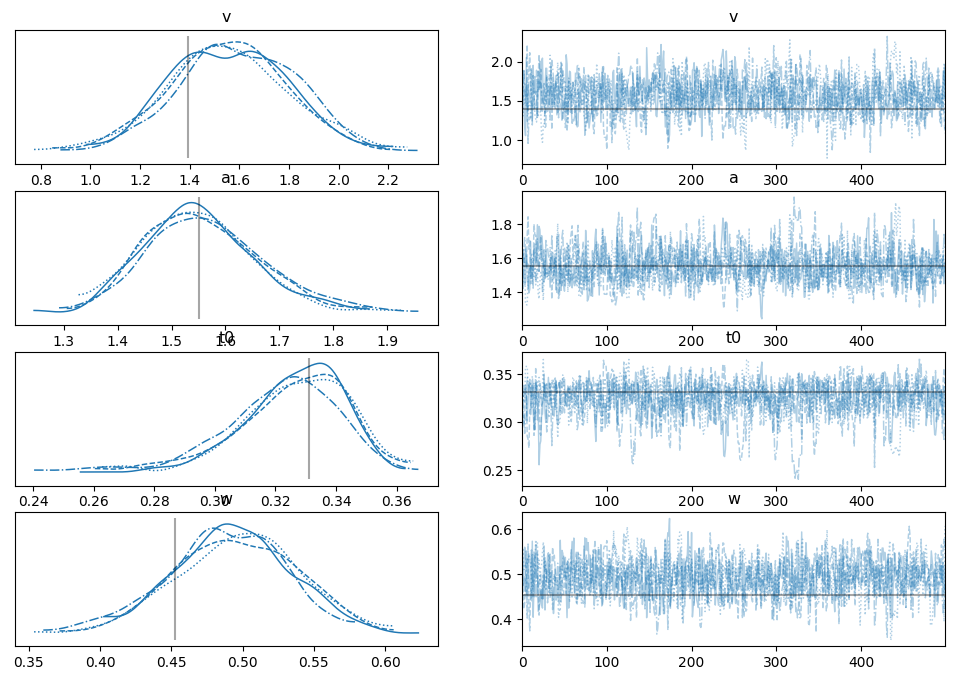

In [8]:
# plot the traces
params = prior_samples[0]
_ = az.plot_trace(
    idata,
    lines=[
        ("v", {}, params[0]),
        ("a", {}, params[1]),
        ("t0", {}, params[2]),
        ("w", {}, params[3]),
    ],
)

In [10]:
rhat = az.rhat(idata)
print(rhat)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    v        float64 1.004
    a        float64 1.003
    t0       float64 1.001
    w        float64 1.002


Both the trace plots and the $\hat R$ statistic indicate good convergence of the chains, so wee see that in principle the likelihood can be used in this setup. We have sampled a number of data sets using `pymc_sample.py`. The obtained samples can now be compared to Stan.

In [7]:
samples_pymc = np.load("assets/samples_pymc.npy")
samples_stan = np.load("assets/samples_stan_small.npy")
samples_pymc.shape

(50, 4, 500, 4)

In [8]:
high_rhat = []
valid_samples = []
for i in range(N_PYMC):
    rhat = az.rhat(az.convert_to_dataset(samples_pymc[i]))["x"].to_numpy()
    if np.any(rhat > 1.01):
        print(f"{i} - high rhat: {rhat}")
        high_rhat.append(i)
    else:
        valid_samples.append(i)

2 - high rhat: [1.00399587 1.01033848 1.00515198 1.00729697]
6 - high rhat: [1.00223386 1.00815098 1.01120121 1.00667611]
16 - high rhat: [1.01391532 1.00114185 1.00540746 1.00977691]
21 - high rhat: [1.00432618 1.0020494  1.01129801 1.0063448 ]
26 - high rhat: [1.00352082 1.00285483 1.00212915 1.01283529]
36 - high rhat: [1.00777803 1.66680859 1.73433592 1.00614315]
40 - high rhat: [1.00405718 1.01004112 1.0050788  1.01573688]
48 - high rhat: [2.05122054 2.10774228 2.1031196  1.55132299]


Some data sets show insufficient diagnostics under the strict criterion $\widehat R<1.01$, those would have to be resampled using more iterations.

To summarise the posterior distribution, we use the median and a 90%-equal-tailed interval. We define the latter as a function for easier access:

In [9]:
def equal_tailed(data, axis, alpha=0.1):
    return np.abs(
        np.quantile(data, [alpha / 2, 1 - alpha / 2], axis=axis)
        - np.median(data, axis=axis)
    )

We use the datasets with sufficient diagnostics to plot the recovery:

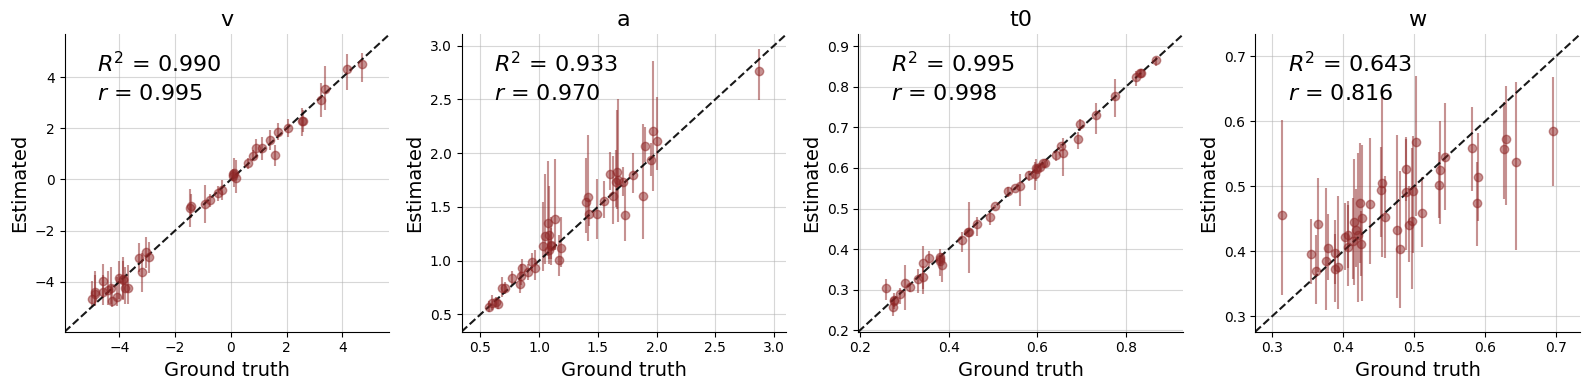

In [10]:
f = plot_recovery(
    np.concatenate(
        np.split(samples_pymc[valid_samples], samples_pymc.shape[1], axis=1), axis=2
    ).squeeze(),
    prior_samples[valid_samples],
    param_names=param_names,
    point_agg=np.median,
    uncertainty_agg=equal_tailed,
)

As a comparison, we can plot the recovery using samples from Stan:

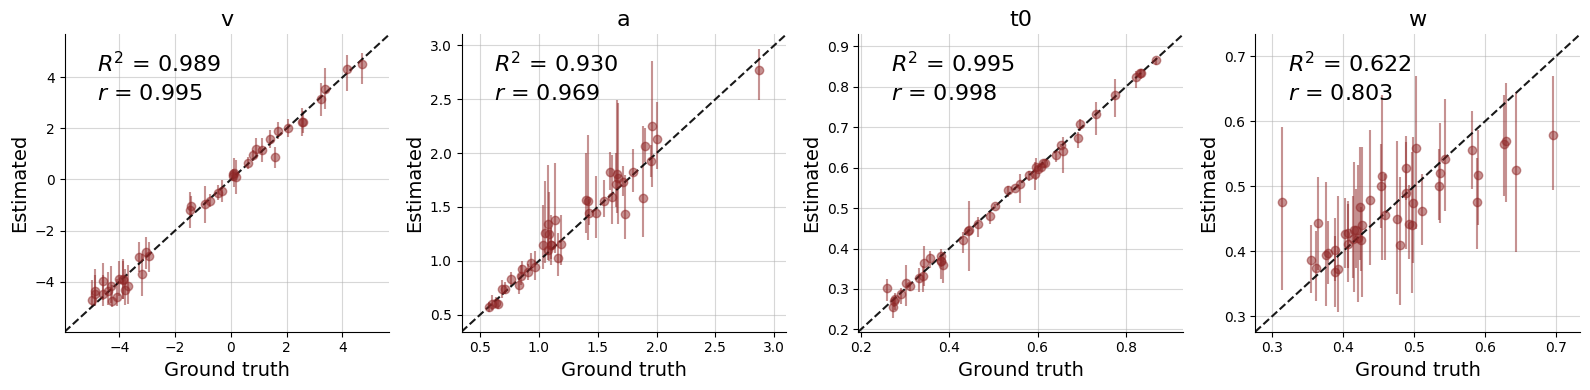

In [11]:
f = plot_recovery(
    samples_stan[valid_samples],
    prior_samples[valid_samples],
    param_names=param_names,
    point_agg=np.median,
    uncertainty_agg=equal_tailed,
)

Finally, we can compare the posterior medians for the estimates of Stan and BayesFlow. The error bars indicate the 90%-equal-tailed interval.

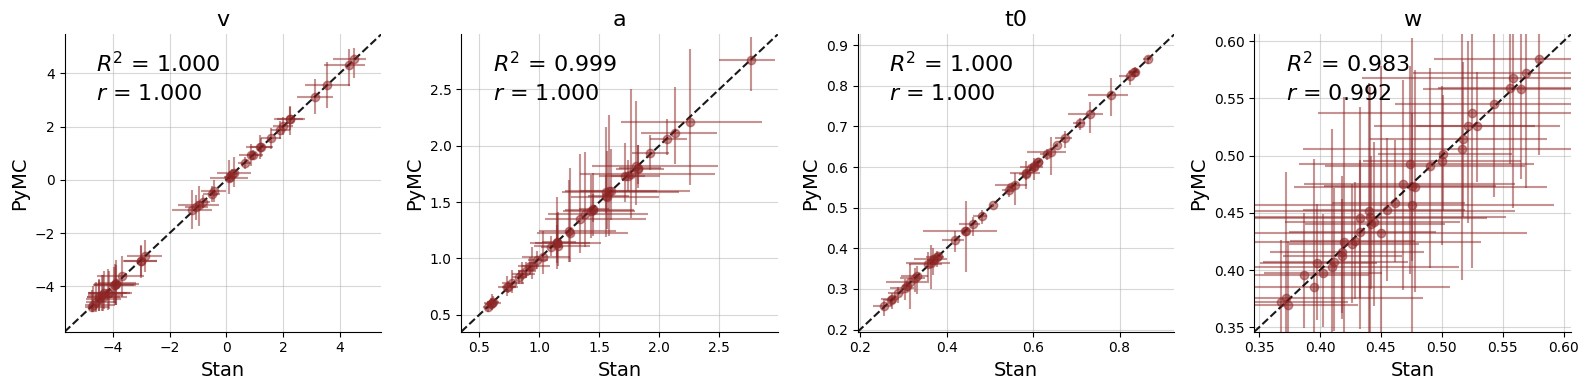

In [12]:
f = compare_estimates(
    samples_stan[valid_samples],
    np.concatenate(
        np.split(samples_pymc[valid_samples], samples_pymc.shape[1], axis=1), axis=2
    ).squeeze(),
    point_agg=np.median,
    uncertainty_agg=equal_tailed,
    label_x="Stan",
    label_y="PyMC",
    param_names=param_names,
)

We see good correspondance between both methods. Given that the convergence was checked, differences arise most probably due to inaccuracies in the approximation in the likelihood.

## Links & References
- [BayesFlow](https://github.com/stefanradev93/BayesFlow)
- [Stan](https://mc-stan.org/)
- [PyMC](https://www.pymc.io/)